# SOC LEAF Example
In this example, SOC LEAF for Maize, rainfed, plant residues removed, traditional tillage production will be developed for a 2030 and 2050 scenario. The process assumes that the land use is kept the same, and that weather and crop data do not change over time, generating LEAF for the input land use map using the default values previously mentioned on [SOC Documentation](../documentation/SOC_Documentation.md). 

A similar approach can be implemented with a different land use map and/or using primary data regarding yields, plant cover, plant residues, soil and weather data. The methods can be changed to simulate crop rotations, organic ammendments, multi-crop systems, among others.

## Data Download and Processing
As explained in SOC Documentation, several data layers need to be downloaded first. This examples uses all potential locations where maize could be grown under rainfed conditions, according to [FAO GAEZ](https://www.fao.org/gaez/en/) v2. A newer version (v5 on the moment of publishing) has been released but to keep consistency with original SOC method framework it has not been updated.

### Soil & Weather
Precipitation and air temperature data have been downloaded and processed. It be found under [data/](../data/). SoilGrids data have been downloaded and processed into UHTH zones in the needed format and is also available in the same folder. 

**🚧 TODO: Update reference 🚧**
This data is too large to be be hosted in a github repository. Instructions into how to download it can be found on XXX

### Crop Data
Land use layer has been adapted from Morais, Teixeria & Domingos (2019) and can be found under [examples/soc_ex_data](../examples/soc_ex_data/).

Commodity yield input data from FAO has already been summarized and can be found at [data/crops/fao_crop_yields_1423.csv](data/crops/fao_crop_yields_1423.csv) file. The needed SPAM data has been downloaded into [data/crops/spam2020V2r0_global_yield](data/crops/spam2020V2r0_global_yield) folder - only Maize data is uploaded, but other crops data layers are recommended to be placed under the same folder.

All other needed data to calculate potential crop evapotranspiration, including pre-calculated PET-location based layer, $K_c$ values, stage durations, as well as other supporting data has been uploaded into [data/crops](../data/crops/) folder.

## Data Processing
Now that all data has been downloaded and prepared, the following modules are needed

In [7]:
# Modules importing
import polars as pl
import matplotlib.pyplot as plt
import importlib
import os
import pandas as pd

import sbtn_leaf.RothC_Raster as rothC
import sbtn_leaf.cropcalcs as cropcalcs
import sbtn_leaf.map_plotting as mplot

def reload_cropcalcs():
    importlib.reload(cropcalcs)

def reload_rothC():
    importlib.reload(rothC)

def reload_mplot():
    importlib.reload(mplot)

Now the rest of the data can be prepared to calculate new LEAFs. The `cropcals.prepare_crop_data()` function automatizes the creation of yields maps, monthly plant cover, monthly PET, monthly irrigation, and monthly plant residue for a given land use commodity raster. All these inputs have their own function that can be directly run instead to reflect different primary data.

Before running the function, the following fields should be defined:

In [8]:
lu_filepath = "examples/soc_ex_data/Maize_irr_lu.tif"
spam_maize_all = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_A.tif"
spam_maize_irr = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_I.tif"
spam_maize_rain = "data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_R.tif"
input_data_output_folder = "examples/soc_ex_data"

Now running `cropcals.prepare_crop_data()` to ready all RothC inputs for Maize, rainfed. If this example has already been run, the function will skip generating already generated files. This should take a couple of minutes.

In [ ]:
cropcalcs.prepare_crop_data(
    crop_name = "Maize",
    crop_practice_string = "rf",
    lu_data_path = lu_filepath,
    spam_crop_raster = spam_maize_rain,
    output_data_folder = input_data_output_folder,
    irr_yield_scaling = "rf",
    spam_all_fp = spam_maize_all,
    spam_irr_fp = spam_maize_irr,
    spam_rf_fp = spam_maize_rain
)

Land use binary raster already exist. Skipping...
PET raster already exists — skipping computation.
Irrigation raster already exists — skipping computation.
Creating Maize (corn) shapefile...
Creating yield raster...
Average irrigated ratio: 1.7520839058709115
Average rainfed ratio: 0.9714865494249993
  → Applying rainfed scaling to all‐SPAM yields…
Yield raster written to data/example/Maize_rf_yield_monthly.tif
Creating plant cover raster...
Creating plant residue raster...
All data created for Maize, rf!!!


### Inspecting outputs
Inspecting the yield data results.

In [ ]:
maize_rf_yields = "examples/soc_ex_data/Maize_rf_yield.tif"

Raster has 82,695 different values. Min: 0.20. Max: 13.65
Using quantiles
All positives route


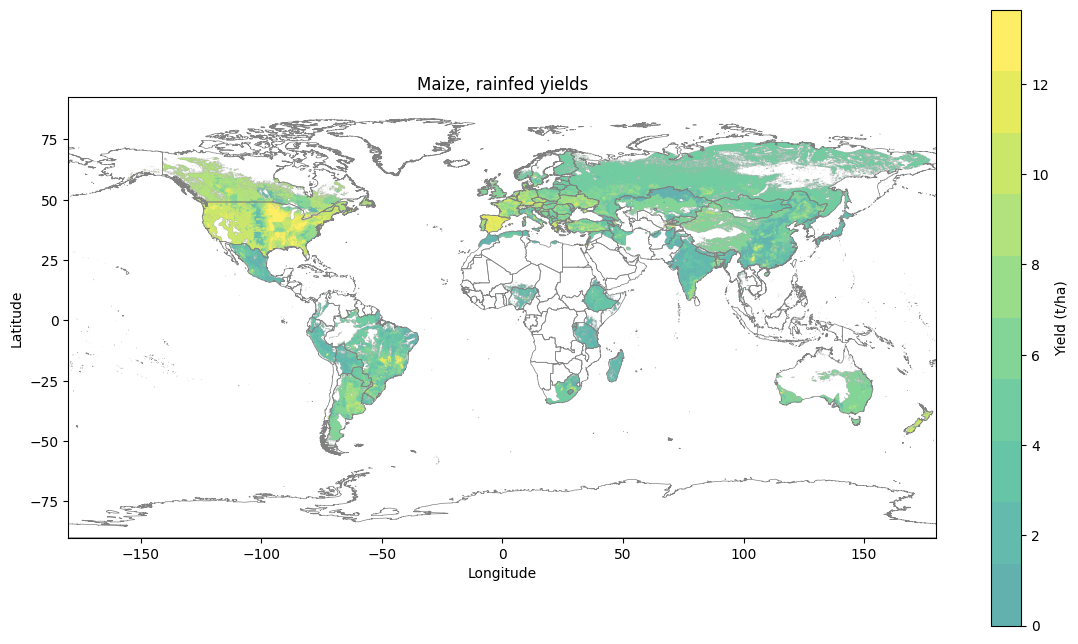

In [ ]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_rf_yields,
    title="Maize, rainfed yields",
    label_title="Yield (t/ha)",
    quantiles=10
)

Maize PET - Monthly

In [ ]:
maize_pet_monthly = "examples/soc_ex_data/Maize_pet_monthly.tif"

Raster has 993,711 different values. Min: 0.00. Max: 256.88
Using quantiles
All positives route


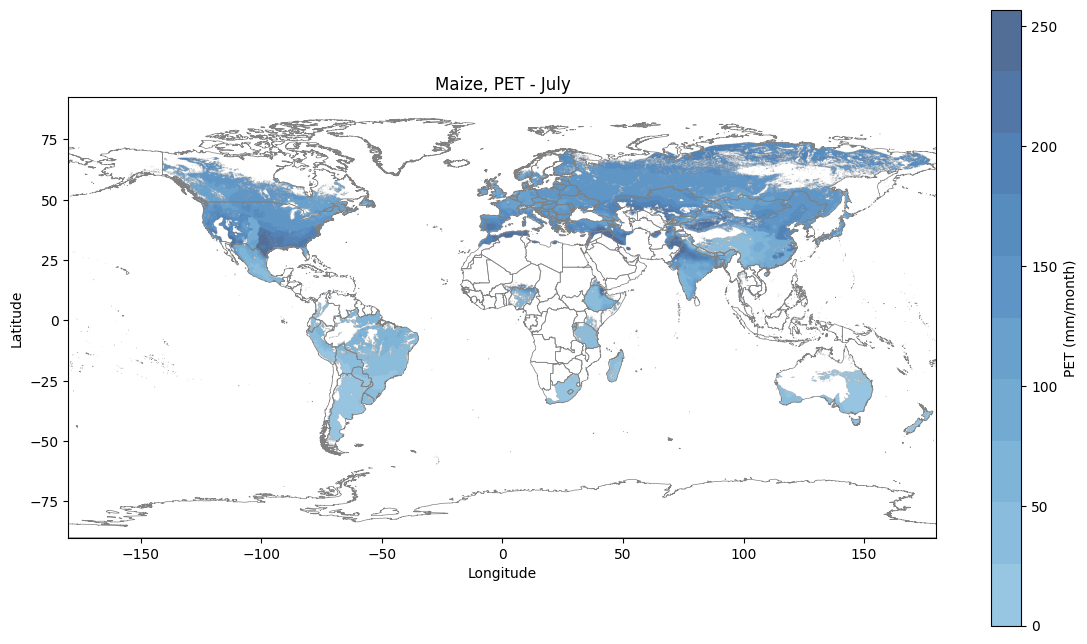

In [ ]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_pet_monthly,
    title="Maize, PET - July",
    raster_band=7,
    label_title="PET (mm/month)",
    quantiles=10,
    cmap="Blues"
)

## RothC Modelling
With all data generated, the RothC model can be run. SoilGrids SOC data is from 2016, so in order to generate 2030 and 2050 maps aligned with SBTi's short and long-term targets, two LEAFs set will be generated: 34 and 54 years. Further, in this case, plant residues will be removed from the field, and traditional tillage applied.

Defining the needed additional inputs:

In [ ]:
evap = "examples/soc_ex_data/Maize_pet_monthly.tif"
pc = "examples/soc_ex_data/Maize_pc_monthly.tif"
leaf_output_folder = "examples/soc_ex_output"

Now running the RothC model. Depending on the amount of years and land modelled, this could take from a few minutes to 1+ hours.

Running for 2030 scenario 

In [ ]:
leaf_maize_rf_resoff_ct_2030 = rothC.run_RothC(
    crop_name = "Maize",
    practices_string_id= "rf_resoff_ct",
    n_years = 34,
    save_folder = leaf_output_folder,
    data_description = "RothC model results after 34 years for Maize, rainfed, residues removed from field, conventional tillage",
    lu_fp = lu_filepath,
    evap_fp = evap,
    pc_fp = pc
)

Loading environmental data...
Loading crop data...
Running RothC...


c:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\leaf_utils\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 408/408 [17:44<00:00,  2.61s/it]


#### Checking results
Now that results have been generated, they can be inspected.

In [ ]:
leaf_maize_rf_resoff_ct_2030_tif = "examples/soc_ex_output/Maize_rf_resoff_ct_34y_SOC.tif"

Checking the properties of the raster...

In [ ]:
mplot.inspect_raster(leaf_maize_rf_resoff_ct_2030_tif)

File: LEAFs/example/Maize_rf_resoff_ct_34y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 35
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: RothC model results after 34 years for Maize, rainfed, residues removed from field, conventional tillage
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.81576681137085
  Max Value: 166.87579345703125
  Mean Value: 55.2380485534668
  Standard Deviation: 20.117786407470703

Band 2:
  Data Type: float32
  Min Value: 6.573349475860596
  Max Value: 154.8661346435547
  Mean Value: 52.665000915527344
  Standard Deviation: 20.185115814208984

Band 3:
  Data Type: float32
  Min Value: 6.4735636711120605
  Max Value: 146.12

Checking Global SOC evolution. This can be replicated or zoomed into a particular region or production unit.

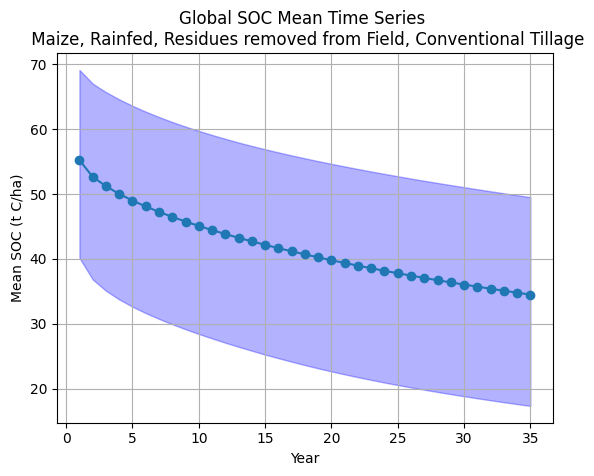

In [ ]:
mplot.plot_multiband_raster_timesires(leaf_maize_rf_resoff_ct_2030_tif, "Global SOC Mean Time Series \n Maize, Rainfed, Residues removed from Field, Conventional Tillage", show_iq=True)

It can be seen that, on average, SOC would be depleted under this operating conditions if kept over time.

Checking LEAF map for 2030

Raster has 1,023,086 different values. Min: 5.74. Max: 82.79
Using quantiles
All positives route


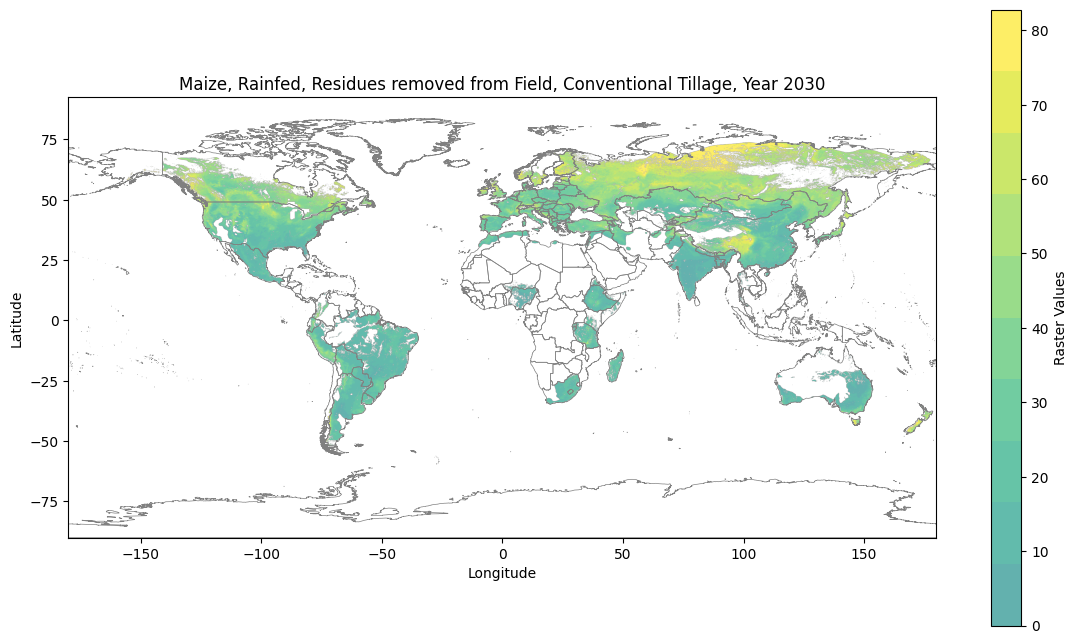

In [ ]:
mplot.plot_raster_on_world_extremes_cutoff(leaf_maize_rf_resoff_ct_2030_tif, "Maize, Rainfed, Residues removed from Field, Conventional Tillage, Year 2030", raster_band=34, alpha=1, quantiles=10)

Now checking how it changed between the baseline and 2030

In [ ]:
pct_change_2030 = rothC.calcuate_annual_perc_changes(leaf_maize_rf_resoff_ct_2030_tif)

Raster has 983,610 different values. Min: -81.31. Max: -9.85
Using quantiles
All negatives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Conventional Tillage'}, xlabel='Longitude', ylabel='Latitude'>)

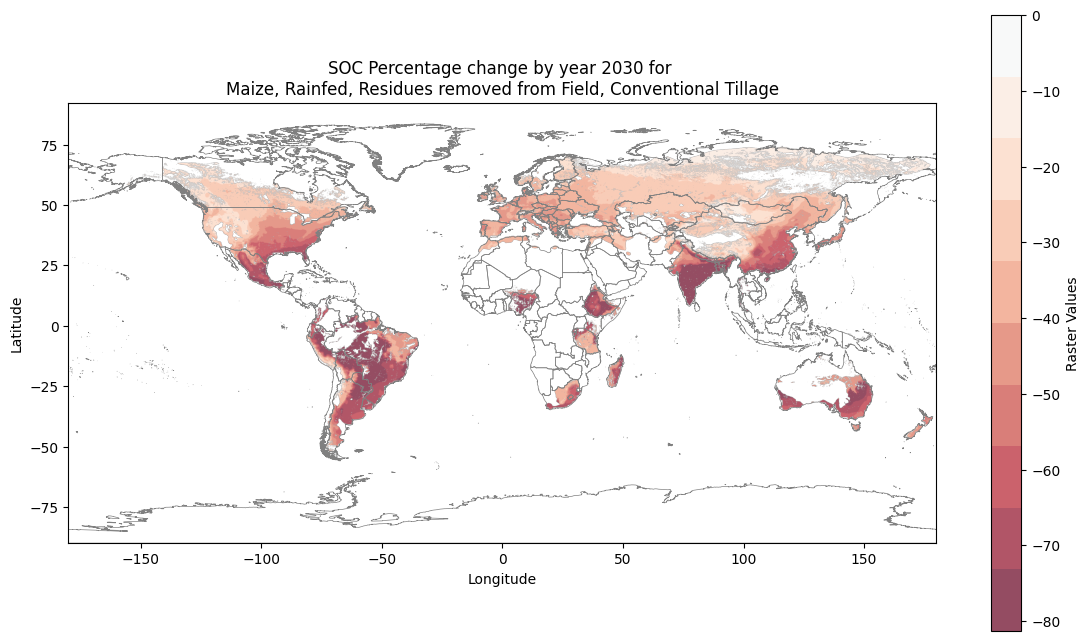

In [ ]:
mplot.plot_da_on_world_extremes_cutoff(pct_change_2030, "SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Conventional Tillage", band=34, cmap="RdBu", quantiles=10)

Where it can be noted that there is no place where this operating conditions would increase SOC. Rather, SOC would decrease between 10% and 80% throughout the globe.